In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,make_scorer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.callbacks import EarlyStopping
import math
#from keras.wrappers.scikit_learn import KerasClassifier


In [55]:
path = '/Users/HP Spectre/OneDrive - student.kit.edu/uni/Master/Lissabon Kurse/Intelligent Systems/IntSysGroup6/'

data = pd.read_csv(path+'Project/data/robot_inverse_kinematics_dataset.csv')
X = data.iloc[:,6:].to_numpy()
y = data.iloc[:,0:5].to_numpy()
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_Y.fit_transform(y)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.2)

(15000, 5)


In [56]:
# Define a function to create the Keras model
def create_model(neurons,dropout_rate,hidden_layers, batch_size= 32,activation_function='relu',epochs=10):
    model = Sequential()
    input_dim = 3
    output_dim = 5
    model.add(Dense(neurons, input_dim=input_dim, activation=activation_function))
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation=activation_function))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    return model



In [57]:

model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=32, verbose=0,neurons=32,dropout_rate=0.0,hidden_layers= 2,activation_function='relu')

hidden_layers = [3,4,5]
neurons = [64,128,256]
dropout_rate = [0.0,0.1,0.3]
activation_function = ['relu','tanh']
batch_size = [32,64,128,256]
epochs = [10,20,50]

param_grid = dict(hidden_layers=hidden_layers,
                  neurons=neurons,
                    dropout_rate=dropout_rate,
                   activation_function=activation_function,
                   batch_size=batch_size,
                   epochs=epochs)



In [59]:
# Create a Random Search instance

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')

random_search = RandomizedSearchCV(
    estimator=model,       
    param_distributions=param_grid,  
    cv=3,                   # Number of cross-validation folds
    n_iter=100,
    n_jobs=-1,               
    scoring='neg_mean_absolute_error'  # Scoring metric
)

search_result = random_search.fit(X_train, y_train)

C:\Users\HP Spectre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\HP Spectre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [ ]:
%store search_result
# print("Best MAE: %f using %s" % (search_result.best_score_, search_result.best_params_))

INFO:tensorflow:Assets written to: C:\Users\HPSPEC~1\AppData\Local\Temp\tmponliqusn\assets


INFO:tensorflow:Assets written to: C:\Users\HPSPEC~1\AppData\Local\Temp\tmponliqusn\assets


Stored 'search_result' (RandomizedSearchCV)
Best MAE: -0.218762 using {'neurons': 256, 'hidden_layers': 4, 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 256, 'activation_function': 'relu'}


In [74]:
best_model_indices = np.argsort(random_search.cv_results_['mean_test_score'])[-3:]
worst_model_indices = np.argsort(random_search.cv_results_['mean_test_score'])[:3]

# Print the best 3 MAE models and their hyperparameters
print("Best 3 Models:")
for idx in best_model_indices:
    mae = -random_search.cv_results_['mean_test_score'][idx]
    hyperparameters = random_search.cv_results_['params'][idx]
    print(f'MAE: {mae}, Hyperparameters: {hyperparameters}')

# Print the worst 3 MAE models and their hyperparameters
print("\nWorst 3 Models:")
for idx in worst_model_indices:
    mae = -random_search.cv_results_['mean_test_score'][idx]
    hyperparameters = random_search.cv_results_['params'][idx]
    print(f'MAE: {mae}, Hyperparameters: {hyperparameters}')

Best 3 Models:
MAE: 0.2130351222218534, Hyperparameters: {'neurons': 64, 'hidden_layers': 5, 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 64, 'activation_function': 'relu'}
MAE: 0.2129698344707344, Hyperparameters: {'neurons': 64, 'hidden_layers': 3, 'epochs': 50, 'dropout_rate': 0.0, 'batch_size': 64, 'activation_function': 'relu'}
MAE: 0.21273260316040543, Hyperparameters: {'neurons': 256, 'hidden_layers': 4, 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 128, 'activation_function': 'relu'}

Worst 3 Models:
MAE: 0.23496219564639173, Hyperparameters: {'neurons': 64, 'hidden_layers': 4, 'epochs': 10, 'dropout_rate': 0.3, 'batch_size': 256, 'activation_function': 'tanh'}
MAE: 0.2349235122784785, Hyperparameters: {'neurons': 128, 'hidden_layers': 5, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 64, 'activation_function': 'tanh'}
MAE: 0.23489504887177848, Hyperparameters: {'neurons': 128, 'hidden_layers': 4, 'epochs': 10, 'dropout_rate': 0.1, 'batch_size': 32, 'activation_functio

In [61]:
results_df = pd.DataFrame(search_result.cv_results_)
results_df.head()
results_df.to_csv('random_search_results.csv', index=False)

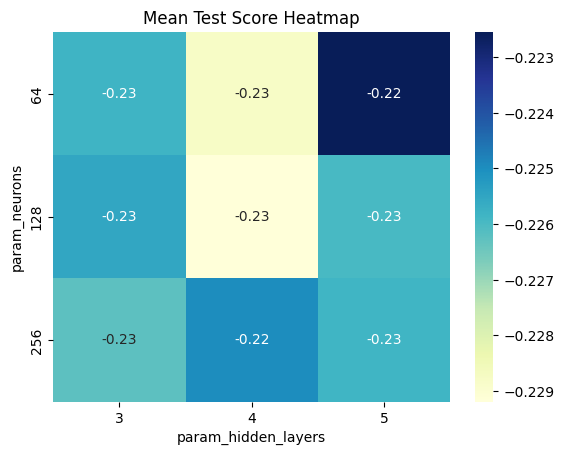

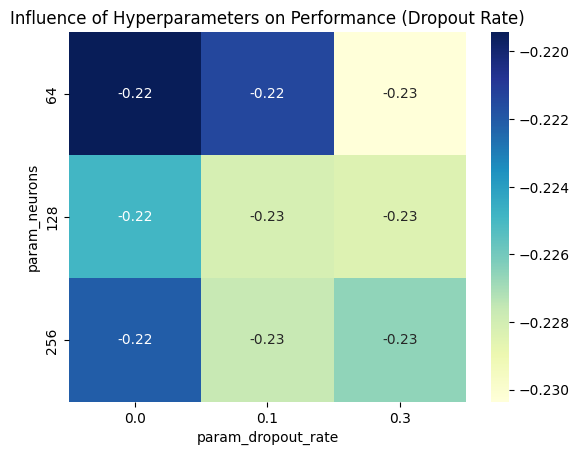

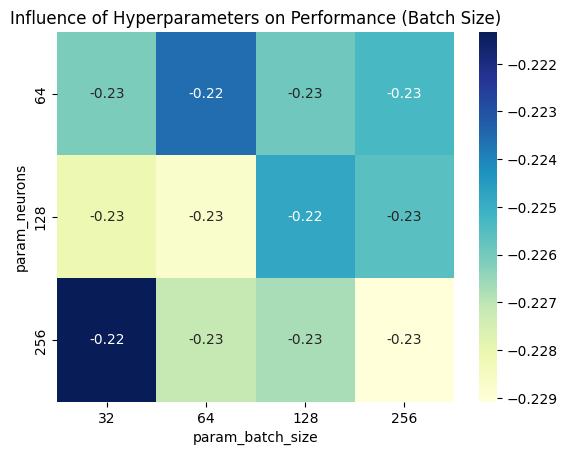

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the grid search results to a DataFrame
results_df = pd.DataFrame(search_result.cv_results_)

# Heatmap for mean test scores
pivot_table = results_df.pivot_table(values='mean_test_score', index='param_neurons', columns='param_hidden_layers')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Mean Test Score Heatmap')
plt.show()


pivot_table = results_df.pivot_table(values='mean_test_score', index='param_neurons', columns='param_dropout_rate')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Influence of Hyperparameters on Performance (Dropout Rate)')
plt.show()

# Create a heatmap for 'batch_size' hyperparameter
pivot_table = results_df.pivot_table(values='mean_test_score', index='param_neurons', columns='param_batch_size')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Influence of Hyperparameters on Performance (Batch Size)')
plt.show()

In [70]:
random_search.cv_results_['mean_test_score'].argmax()


56